# Word Analysis
Analyse the articles by word counts, word importances and other features!

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
# Add functions path
import sys
sys.path.append('../Functions')
from datasets import load_stratified_dataset

#### Load dataset

In [2]:
df = load_stratified_dataset(path='../Datasets/dataset_categories/dataset_big.csv', labels='category', samples_per_label=1000000)

Smallest sample size in dataset is 12525 samples!


***
## Naive Bayes for word importances

In [3]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

text = df.text_lem.values
# Number of times the words have to occur at least
min_df=10

# ngram_range only use 1 word, stop_words=english remove common words(eg: a, an, the)
# CountVectorizer ignores difference between lower and upper case and puncuation
vect = CountVectorizer(ngram_range=(1,1), stop_words='english', min_df=min_df)

# CountVectorizer converts list of strings to matrix with: rows = observation, columns = terms in text, values=count/document
X = vect.fit_transform(text)
words = vect.get_feature_names()


# Turn result to dummies, so that columns are in correct order
d = {}
count=0
for i in df.category.unique():
    d[i] = count
    count += 1
df['category_num'] = [d[i] for i in df.category]

y = df.category_num

# Remove alpha to prevent bias
clf = MultinomialNB(alpha=1.e-10)
clf.fit(X,y)

likelihood_df_raw = pd.DataFrame(clf.feature_log_prob_.transpose(),columns=df.category.unique(), index=words)

***
## Most used words

***
## Word importances for every category

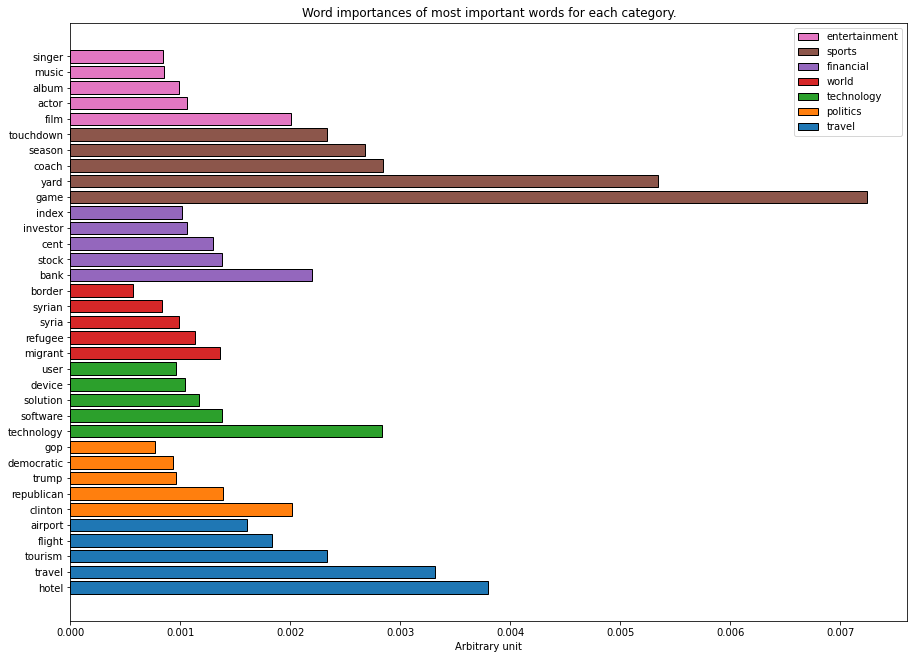

In [4]:
num_words = 5 # num_words
fig = plt.figure(figsize=(15,11))
ax = plt.subplot(111)
likelihood_df = {}
for category in df.category.unique():
    likelihood_df[category] = np.exp(likelihood_df_raw[category]) - np.sum(np.exp(likelihood_df_raw.drop(category, axis=1)), axis=1)
    #likelihood_df[category] = np.exp(likelihood_df_raw[category]) - np.exp(np.sum(likelihood_df_raw.drop(category, axis=1), axis=1))
    
    # Sort likelihood
    likelihood_df[category] = likelihood_df[category].sort_values(ascending=False)

    top = likelihood_df[category][:num_words]
    
    ax.barh(top.index, top, edgecolor='black', label=category)

ax.set_title('Word importances of most important words for each category.')
ax.set_xlabel('Arbitrary unit')
    
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1]);

***
## Word count per category

In [5]:
# Create list containing empty list for each category
l = [[] for i in df.category.unique()]
ct = 1
total = y.shape[0]
# Append vectors depending on their category
for category, count in zip(y, X.toarray()):
    print('Get vectors for each category: {:.2f}%'.format(ct/total*100), end='\r')
    ct+=1
    l[category].append(count)

In [6]:
l2 = []
count=1
# Get the sum of counts for each category
for cat in l:
    print('Count words for each category: {:.2f}%'.format(count/len(l)*100), end='\r')
    count+=1
    cat = np.array(cat)
    tmp = cat.sum(axis=0)
    l2.append(tmp)
    
l2 = np.array(l2)

In [7]:
# Transform counts in Dataframe
word_count = pd.DataFrame(l2.transpose(), columns=df.category.unique(), index=words)

In [8]:
word_count[10035:10040]

,travel,politics,technology,world,financial,sports,entertainment
de2ce65,0,3,0,0,0,30,3
de2ced,0,0,4,0,0,11,2
de2e,0,0,3,0,0,7,1
de2e6,1,41,6,0,0,46,12
de2j,2,0,1,0,0,18,5


In [9]:
word_count.loc['business']

travel            8335
politics          3357
technology       13026
world             1638
financial         9831
sports             933
entertainment     1878
Name: business, dtype: int64

***
## Word embedding
Save Word embeddings with different vocabulary words and sizes.

In [10]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
import gensim

#### Create, fit and save embedding vectors

In [11]:
# Embedding dimension
emb_dims = [2]
# Vocabulary size
vocab_sizes = [30]

for emb_dim in emb_dims:
    for vocab_size in vocab_sizes:

        # Get vocabulary
        vocabulary = set()
        for category in likelihood_df.keys():
            vocabulary.update(likelihood_df[category].index[:vocab_size])
        vocabulary = list(vocabulary)

        # Name of embedding
        name = 'voc_' + str(len(vocabulary)) + '_dim_' + str(emb_dim)

        # Size is embedding dimension
        model = Word2Vec(size=emb_dim, max_vocab_size=10000, window=5, min_count=1, workers=1)
        # Set vocabulary
        model.build_vocab(sentences=[vocabulary])
        # Train model on lemmatized articles
        model.train(df.text_lem, total_examples=1, epochs=model.epochs)
        # Create word vectors
        word_vectors = model.wv
        # Save Word vectors
        word_vectors.save('word_embeddings/' + name + '.word_vectors')
        # Get sizes
        print('Embedding vectors represent {} vocabularies using {} embedding dimensions!'.format(len(word_vectors.vocab), word_vectors.vector_size))

Embedding vectors represent 210 vocabularies using 2 embedding dimensions!


In [12]:
#word_vectors.most_similar('str')

***
## Word map
Create a map showing calculated relations between different words.

#### Word embeddings
Load the specified word embedding. Possibilities are given in ver.

In [13]:
# Load embedding vectors
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load('word_embeddings/broad_test/voc_280_dim_30.word_vectors', mmap='r')

#### Try out likelihood directly

In [14]:
class random_class():
    def __init__(self, vocab, vectors):
        self.vocab = vocab
        self.vectors = vectors
        
df_vocab = pd.DataFrame(likelihood_df).loc[vocabulary]
word_vectors = random_class(df_vocab.index, df_vocab.values)

#### Use Kmeans to predict categories

In [15]:
# Set number of clusters
n_clusters = 7

In [16]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(word_vectors.vectors)
idx = kmeans.fit_predict(word_vectors.vectors)
kmeans.score(word_vectors.vectors)

-0.001346081681436595

#### Use PCA to reduce dimensionality to 2d
Important to make problem plotable.

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)

#### Divide words and corresponding vectors to clusters

In [18]:
clusters = []
# Loop over all clusters
for cluster in range(0,n_clusters):
    words = []
    for word, idx_, vec in zip(word_vectors.vocab, idx, pca.fit_transform(word_vectors.vectors)):
        # Add word and vectors to corresponding cluster
        if(idx_ == cluster):
            words.append((word,vec))
    clusters.append(np.array(words))
clusters=np.array(clusters)

#### Plots

In [19]:
# Create dataframe
vectors2d = pca.fit_transform(word_vectors.vectors).T
word_map = pd.DataFrame()
word_map['word'] = word_vectors.vocab
word_map['cluster'] = idx
word_map['x'] = vectors2d[0]
word_map['y'] = vectors2d[1]
word_map.to_csv('word_map/data.csv', index=False)

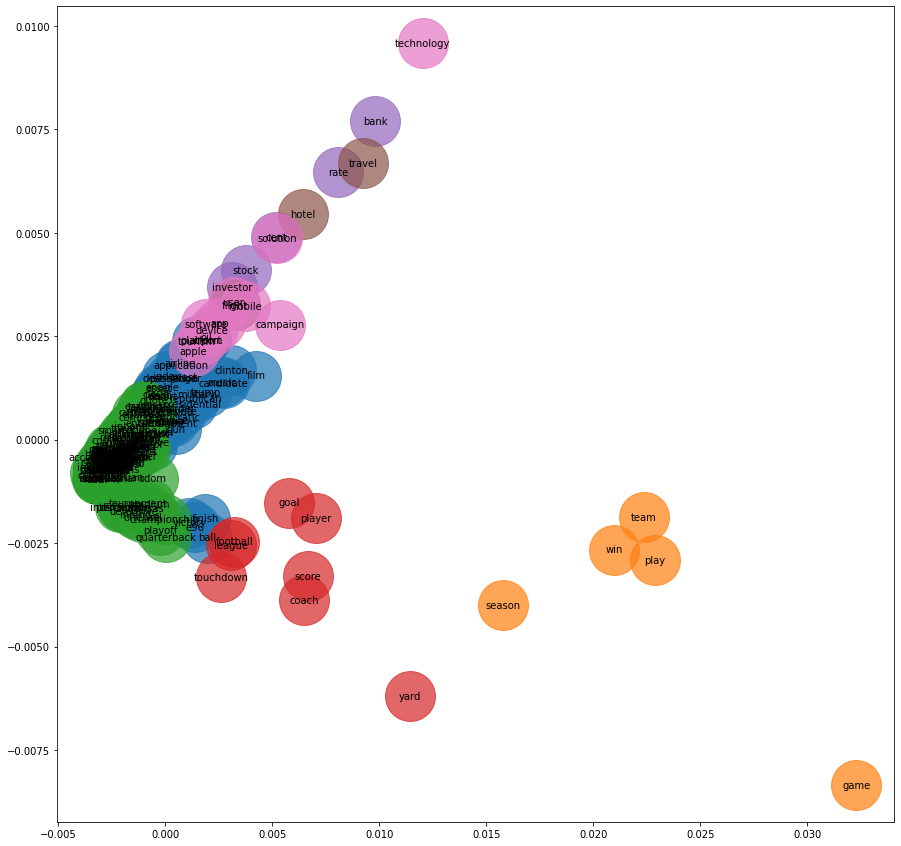

In [20]:
# Plot with matplotlib for fast overview
if True:
    fig, ax = plt.subplots(figsize=(15,15))
    for cluster in clusters:
        x = [i[0] for i in cluster.T[1]]
        y = [i[1] for i in cluster.T[1]]
        ax.plot(x, y, marker='o', ms=50, alpha=0.7, linestyle='none')
        for word, vec in cluster:
            plt.annotate(word, (vec[0], vec[1]), ha='center', va='center', size=10)

In [21]:
%matplotlib inline

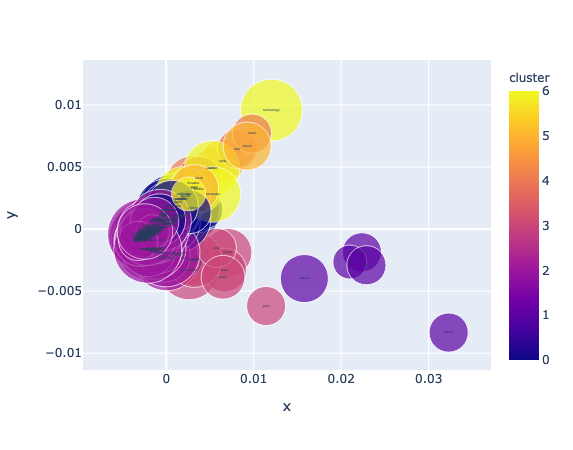

In [26]:
import plotly.express as px

df = pd.read_csv('word_map/data.csv')
df.dropna(inplace=True)
df['word_length'] = [len(s) for s in df.word.values]

fig = px.scatter(df, x="x", y="y",
                 color="cluster",
                 text='word',
                 size='word_length',
                 size_max=50
)

fig.update_traces(textposition='middle center', textfont_size=3)

#fig.update_layout(textfont_size=10)

fig.show()

In [23]:
# for output config: 
import bokeh.io 
bokeh.io.reset_output()
# shows output in notebook:
bokeh.io.output_notebook()

Loading BokehJS ...

In [24]:
from bokeh.models import ColumnDataSource, Label, LabelSet, Range1d
from bokeh.plotting import figure, output_file, show

#output_file("label.html", title="label.py example")

source = ColumnDataSource(data=dict(height=[66, 71, 72, 68, 58, 62],
                                    weight=[165, 189, 220, 141, 260, 174],
                                    names=['Mark', 'Amir', 'Matt', 'Greg',
                                           'Owen', 'Juan']))

p = figure(title='Dist. of 10th Grade Students at Lee High',
           x_range=Range1d(140, 275))
p.scatter(x='weight', y='height', radius=2, source=source)
p.xaxis[0].axis_label = 'Weight (lbs)'
p.yaxis[0].axis_label = 'Height (in)'

labels = LabelSet(x='weight', y='height', text='names', level='glyph',
                  text_font_size='20pt',
              x_offset=0, y_offset=0, source=source, render_mode='canvas')

citation = Label(x=70, y=70, x_units='screen', y_units='screen',
                 text='Collected by Luke C. 2016-04-01', render_mode='css',
                 border_line_color='black', border_line_alpha=1.0,
                 background_fill_color='white', background_fill_alpha=1.0)

p.add_layout(labels)
p.add_layout(citation)

show(p)


In [30]:
"""Bokeh range select test."""
import numpy as np

from bokeh.models import BoxSelectTool
from bokeh.models.callbacks import CustomJS
from bokeh.plotting import figure, show, output_file
from bokeh.layouts import column as vplot

x = np.linspace(0, 10, 500)
y = np.sin(x) + np.random.normal(size=500)

p1 = figure(plot_width=800, plot_height=250, min_border_top=0, min_border_bottom=0)
p1.line(x, y)

p2 = figure(plot_width=800, plot_height=80, min_border_top=0, min_border_bottom=0, toolbar_location=None, tools='')
p2.line(x, y)

callback = CustomJS(args=dict(p1=p1), code="""
    g = cb_data.geometry
    p1.get('frame').get('x_ranges').default.set({start: g.x0, end: g.x1})""")

p2.add_tools(BoxSelectTool(callback=callback, dimensions=['width']))

output_file("bar.html")

show(vplot(p1, p2))

AttributeError: unexpected attribute 'callback' to BoxSelectTool, similar attributes are js_event_callbacks